In [1]:
import pandas as pd
import numpy as np
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)
data = []
%config Config.use_jedi = False

## Conversor Alfabetos

one_letter	two_letter	ipa
a	AA	ɑ
@	AE	æ
A	AH	ʌ
c	AO	ɔ
W	AW	aʊ
x	AX	ə
N/A	A	ɚ
Y	AY	aɪ
E	EH	ɛ
R	ER	ɝ
e	EY	eɪ
I	IH	ɪ
X	IX	ɨ
i	IY	i
o	OW	oʊ
O	OY	ɔɪ
U	UH	ʊ
u	UW	u
N/A	UX	ʉ
b	B	b
C	CH	tʃ
d	D	d
D	DH	ð
F	DX	ɾ
L	EL	l̩
M	EM	m̩
N	EN	n̩
f	F	f
g	G	ɡ
h	HH	h
h	H	h
J	JH	dʒ
k	K	k
l	L	l
m	M	m
n	N	n
G	NG	ŋ
G	NX	ŋ
p	P	p
Q	Q	ʔ
r	R	ɹ
s	S	s
S	SH	ʃ
t	T	t
T	TH	θ
v	V	v
w	W	w
H	WH	ʍ
y	Y	j
z	Z	z
Z	ZH	ʒ
a~		ɑ~
e~		e~
i~		i~
o~		o~
u~		u~
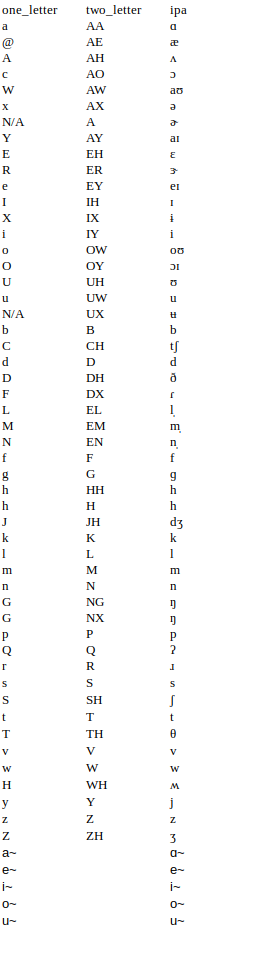

In [2]:
conversor = pd.read_clipboard()

In [3]:
conversor.head()

,one_letter,two_letter,ipa
0,a,AA,ɑ
1,@,AE,æ
2,A,AH,ʌ
3,c,AO,ɔ
4,W,AW,aʊ


## Default Class

In [143]:
import glob, os
from io import StringIO
import collections, numpy
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import re
import ipdb;

def get_words(x):
	temp_result = x.split('\t\t')[0]
	if temp_result.find('\t') > -1:
			temp_result = x.split('\t')[0]
	if temp_result.find(' ') > -1:
			temp_result = x.split()[0]
	return temp_result
def get_phonemes(x):
	temp_result = ""
	if x.find('\t\t') > -1:
			temp_result = x.split('\t\t')[1]
	if (temp_result.find('\t') > -1) or (len(temp_result) == 0 and x.find('\t') > -1):
			temp_result = x.split('\t')[1]
	if (temp_result.find(' ') > -1) or (len(temp_result) == 0 and x.find(' ') > -1):
			temp_result = x.split()[1:]
	return temp_result
	
def process_data(name, normalized=True, reference_dict=None):
	perdas = 0
	total = 0
	if name == 'cmu':
		df = pd.read_csv('../data/external/cmudict.dict', sep='\t', header=None, names=['lines'])
		df.lines = df.lines.str.replace('\d', '') #Dígitos representam apenas entonação https://en.wikipedia.org/wiki/ARPABET
		df['words'] = df.lines.str.split().str[0]
		df['phonemes']  = df.lines.str.split().str[1:]
		df = df.drop(labels=df[df.lines.str.contains('#')].index).reset_index(drop=True)
		total = len(df)
	if name == 'dict_br':
		df = pd.read_csv('../data/external/dictionary.dic', sep=';', header=None, names=['lines'])
		df.lines = df.lines.str.replace('sp$', '').str.replace('sp $', '')
		df = (
				df
				.drop(labels=df[df.lines.str.contains('\[\]')].index)
				.reset_index(drop=True)
		)
		df['words'] = df.lines.apply(get_words)
		df['phonemes'] = df.lines.apply(get_phonemes)
		df = (
			df
			.drop(labels=df[df.phonemes.apply(lambda x : 'sil' in x)].index)
			.reset_index(drop=True)
		)
		total = len(df)
	if name == 'ljspeech':
		df = pd.read_csv('../data/external/LJSpeech-1.1/metadata.csv', sep='|', header=None, names=['ID', 'transcription', 'normalized'])
		np.hstack(df.normalized.str.split().values)
	if name == 'laps' or name == 'const' or name =='cell' or name == 'ljspeech':
		myBigString = ""
		if name == 'laps':
			for file in glob.glob("../data/external/LapsBM1.4/*/*.txt", recursive=True):
				myBigString += open(file).read() + ' '
		if name == 'const':
			for file in glob.glob("../data/external/constituicaoBR/*.txt", recursive=True):
				myBigString += open(file).read() + ' '
		if name == 'cell':
			import pysrt
			for file in glob.glob("../data/external/Cellbit/originals/*.srt", recursive=True):
				subs = pysrt.open(file)
				myBigString += ' ' + subs.text + ' '
		if name == 'ljspeech':
			df = pd.read_csv('../data/external/LJSpeech-1.1/metadata.csv', sep='|', header=None, names=['ID', 'transcription', 'normalized'])
			myBigString = " ".join(
			    df.loc[~df.normalized.isna(), 'normalized'].values
			)
		myBigString = myBigString.replace('\n', '').replace("\'", ' ')
		myBigString = re.sub(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\d]', ' ', myBigString).lower()
		t = collections.Counter(numpy.array(myBigString.split()))
		del myBigString #save memory
		df = pd.DataFrame(list(zip(t.keys(), t.values())), columns=['words', 'ocorrencias'])
		try:
			total = len(df)
			df = df.merge(reference_dict, on='words')
			perdas = 1.0 - (len(df)/total)
		except:
			raise Exception('Deve definir um dicionário para processar')
		df.phonemes = df.phonemes * df.ocorrencias #multiplica as ocorrencias



	unique, counts = np.unique(
			np.hstack(
					df.phonemes.values
			),
			return_counts=True)

	phonemes = pd.DataFrame(list(zip(unique, counts)), columns=['phoneme', 'cmu_dict'])
	
	if name == 'cmu' or name == 'ljspeech':
		phonemes = (
				phonemes
				.merge(conversor, left_on='phoneme', right_on='two_letter')
				.sort_values(by='cmu_dict', ascending=False)
		)
	else:
		phonemes = (
	    phonemes
	    .merge(conversor.drop_duplicates(subset='one_letter'),left_on='phoneme', right_on='one_letter')
	    .sort_values(by='cmu_dict', ascending=False)
	    )

	data = go.Bar(
						x=phonemes.ipa,
						y=(
								100 *
								phonemes.cmu_dict / 
								phonemes.cmu_dict.sum()
						) if normalized else phonemes.cmu_dict,
						name=name
			)

	return df, phonemes, data, perdas, total


## Dicionários

### CMU

In [163]:
cmu_l = process_data('cmu')

### Dict PT_BR

In [164]:
dict_l = process_data('dict_br')

# Voz

### LJSpeech

In [165]:
dict_lj = process_data('ljspeech', reference_dict=cmu_l[0]) #Dicionário Inglês de Referência

### Laps

In [166]:
dict_laps = process_data('laps', reference_dict=dict_l[0])

### Constituição

In [168]:
dict_const = process_data('const', reference_dict=dict_l[0])

### Cellbit

In [171]:
dict_cell = process_data('cell', reference_dict=dict_l[0])

## Bar Graph

In [252]:
data = []

dicts = [cmu_l[2], dict_lj[2], dict_l[2], dict_laps[2], dict_const[2], dict_cell[2]]
colors = ['#2F0446', '#550E7C', '#EBEB02', '#BABA0B', '#696900', '#3E3E00']

for c,d in zip(colors, dicts):
    d['marker'] = dict(color=c)
    data.append(d)

In [253]:
layout = go.Layout(
    title='Distribuição de % de Fonemas',
    xaxis=dict(
        title='Fonemas',
        titlefont=dict(
            size=18,
            ),
        
    ),
    yaxis=dict(
        title='% de Fonemas Relativo',
        titlefont=dict(
            size=18,
        )
    ),
    width=1000,
    height=500,
    bargroupgap=0
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='basic-bar')

## Correlações

In [159]:
myCorr = (
    cmu_l[1].loc[:, ['cmu_dict', 'ipa']] #x
    .merge(dict_lj[1].loc[:, ['cmu_dict', 'ipa']], on='ipa', how='outer',suffixes=('_cmu', '_lj')) #y
    .rename(index=str, columns={"cmu_dict_cmu": "cmu","cmu_dict_lj": "lj"})
    .merge(dict_l[1].loc[:, ['cmu_dict', 'ipa']], on='ipa', how='outer',suffixes=('', '_pt')) #y
    .rename(index=str, columns={"cmu_dict": "pt"})
    .merge(dict_laps[1].loc[:, ['cmu_dict', 'ipa']], on='ipa', how='outer') #y        
    .rename(index=str, columns={"cmu_dict": "laps"})
    .merge(dict_const[1].loc[:, ['cmu_dict', 'ipa']], on='ipa', how='outer',suffixes=('', '_const')) #y
    .rename(index=str, columns={"cmu_dict": "const"})
    .merge(dict_cell[1].loc[:, ['cmu_dict', 'ipa']], on='ipa', how='outer',suffixes=('', '_cell')) #y
    .rename(index=str, columns={"cmu_dict": "cell"})
    .fillna(0)
    .corr()
)
myCorr

,cmu,lj,pt,laps,const,cell
cmu,1.000000,0.906127,0.376204,0.336552,0.345288,0.293922
lj,0.906127,1.000000,0.225259,0.215444,0.240320,0.176875
pt,0.376204,0.225259,1.000000,0.984105,0.964798,0.969174
laps,0.336552,0.215444,0.984105,1.000000,0.988417,0.987151
const,0.345288,0.240320,0.964798,0.988417,1.000000,0.971525
cell,0.293922,0.176875,0.969174,0.987151,0.971525,1.000000


In [256]:
print(myCorr.to_latex(float_format=lambda x: '%10.2f' % x))

\begin{tabular}{lrrrrrr}
\toprule
{} &        cmu &         lj &         pt &       laps &      const &       cell \\
\midrule
cmu   &       1.00 &       0.91 &       0.38 &       0.34 &       0.35 &       0.29 \\
lj    &       0.91 &       1.00 &       0.23 &       0.22 &       0.24 &       0.18 \\
pt    &       0.38 &       0.23 &       1.00 &       0.98 &       0.96 &       0.97 \\
laps  &       0.34 &       0.22 &       0.98 &       1.00 &       0.99 &       0.99 \\
const &       0.35 &       0.24 &       0.96 &       0.99 &       1.00 &       0.97 \\
cell  &       0.29 &       0.18 &       0.97 &       0.99 &       0.97 &       1.00 \\
\bottomrule
\end{tabular}



In [267]:
trace = go.Heatmap(z=myCorr.values.T,
                  x=myCorr.columns,
                  y=myCorr.columns,
                  colorscale=[[0, colors[0]], [1, colors[2]]]
                  )
layout = go.Layout(
    autosize=False,
    width=500,
    height=500,
    title="Matriz de Correlações",
    margin=go.layout.Margin(
        l=70,
        r=70,
        b=70,
        t=70,
        pad=2
    ),
    paper_bgcolor='rgb(255,255,255, 0)',
#     plot_bgcolor='#c7c7c7'
)

fig = go.Figure(data=[trace], layout=layout)
py.iplot(fig, filename='basic-heatmap')

## Perdas de Palavras

In [274]:
print(f'Perda de {round(dict_lj[3] * dict_lj[4]):05} palavras, correspondente a {dict_lj[3] * 100:05.2f} %' )
print(f'Perda de {round(dict_l[3] * dict_l[4]):05} palavras, correspondente a {dict_l[3] * 100:05.2f} %' )
print(f'Perda de {round(dict_laps[3] * dict_laps[4]):05} palavras, correspondente a {dict_laps[3] * 100:05.2f} %' )
print(f'Perda de {round(dict_const[3] * dict_const[4]):05} palavras, correspondente a {dict_const[3] * 100:05.2f} %' )
print(f'Perda de {round(dict_cell[3] * dict_cell[4]):05} palavras, correspondente a {dict_cell[3] * 100:05.2f} %' )

Perda de 01139 palavras, correspondente a 08.28 %
Perda de 00000 palavras, correspondente a 00.00 %
Perda de 00046 palavras, correspondente a 01.68 %
Perda de 00526 palavras, correspondente a 09.87 %
Perda de 03344 palavras, correspondente a 50.08 %
